# Software HW 9

_Due 3/8/2023_

For submission instructions, see the last section!

This HW is long - and you'll play with fitting. There are a number of pitfalls that will lead you to "wrong" answers. IRL, you'd have to depend on your knowledge of the subject matter to catch them - plots that didn't look right, etc. This is part of the reason you can never _really_ trust a computer - you should always know the answer before you have it do something for you. Sometimes you'll be wrong, but mostly it will be wrong. I've done my best to put warnings in this HW, and hopefully I'll help you catch some of the more subtle bugs. But do keep your eyes open, and every single time you make a plot, ask "Does this make sense?"

## Simulating a Detector, Cont'd

The [MATHUSLA](https://mathusla-experiment.web.cern.ch/) detector is being designed to search for Ultra Long-Lived Particles. The detector design itself is a very simple 4 planes of charged particle detector. This detector has no magnetic field, so when a charged particle goes through it, it leaves hits that look like a straight line. We can use least-squares to fit the points, and then recover the original track parameters.

In last week's homework we:

1. Generated a set of straight lines that will hit the detector
1. Simulated the charged particles hitting the detector, generating a set of points

Solutions will get posted over the weekend so you can base this weeks' HW off of those if you wish.

This week:

1. Use least squares to reconstruct the hits back to the line parameters (slope, etc.)
1. Compare with the originally generated tracks to see how well we do
1. Try our hands at smearing the the hits (more on what this means below), and see its effect on the reconstructed hits.

As before, I used regular python to solve this. If you are feeling ambitious, feel free to use `numpy` for all the calculations. It will be faster for large numbers of particles, but requires thinking a little differently about how you do this.

### The detector

We will use the same detector design as last time.

Here are the same set of constants.

_N.B._ The reason not to have hardwired constants by just typing them - which are called ["magic numbers"](https://methodpoet.com/magic-numbers/) in code - is at least two fold:

* The number `100` means a lot less than `det_x_width`
* If you do want to change them, you have to find every `100` and change it - and double check that that `100` is actually a detector size, not a count of 100, etc.

In [ ]:
gun_coordinates = (0, 0, -100)

det_x_width = 100.0
det_y_width = 100.

det_layer_z = [i*4/4 for i in range(5)]

## Generation

We are going to need the particle gun again. Copy in your particle gun from last time below (or use the one in the solutions):

And the `generate_lines` solution from last time:

### Simulate

And, finally, the simulate function from last HW:

## Make some data...

Using the above functions, lets make 1000 particles shot randomly up into the detector, and then the detector hits. We'll fit those next.

In [ ]:
gen_particles = generate_lines(1000)
detector_hits = [simulate(p) for p in gen_particles]

## Fitting with least squares/linear regression

You have encountered least-squares fitting several times over the course of your tenure at UW - at the very least during the 12x labs in physics, and now again in the ML lectures we've just done. Here we need to fit the points in `x,y` vs `z` - to get two slopes and two intercepts. In real life, the particles will leave hits in the detector and we will use those hits to find the slope and offset - so we can tell where they came from. In MATHUSLA, telling where they came from can tell the difference between originating from a well known Standard Model particle, or originating from a new [long-lived particle](https://www.symmetrymagazine.org/article/the-secret-lives-of-long-lived-particles).

Write a method that will take 4 points in `x` (or `y`) and `z`, fit them, and return the slope and offset as a tuple. Create the function `ls_point_fit` in the next cell and make sure it passes the tests in the cell below. Use the cell below to understand more fully the interface. Make sure to add comments to the function definition to outline edge cases.

In [ ]:
# Points are `(x, z)`` pairs, one tuple for each layer (we have 5 layers in MATHUSLA, but this routine should be able to
# handle whatever we give it). It returns a tuple of `(slope, intercept)` for the line.

# Lines with well understood slopes and intercepts
assert ls_point_fit([(0, 0), (1, 1), (2, 2), (3, 3)]) == (1, 0)
assert ls_point_fit([(0, 0), (0, 1), (0, 2), (0, 3)]) == (0.0, 0.0)
# When our simulate function returns None, we should make sure not to fail our fit
# as long as we have enough points.
assert ls_point_fit([(0, 0), (1, 1), (2, 2), (None, 4)]) == (1, 0)
assert ls_point_fit([(0, 0), (1, 1), (2, 2)]) == (1, 0)
assert ls_point_fit([(0, 0), (1, 1)]) == (1, 0)
# And if we don't have enough points, we need to behave "correctly" (as that is going to happen here).
assert ls_point_fit([(0, 0)]) == None
assert ls_point_fit(None) == None

Lets see how well we are doing here. For the x axis, determine the slope and the intercept of all the simulated hits (`detector_hits`) that are given above, and then plot them.

First, make a plot of the reconstructed slope of the x coordinate for each of the 1000 tracks that are in `detector_hits`. Make sure the range along the x-axis is reasonable to see what is going on, and remember to label your axes and a plot title!

Next, grab the generated source slope (`gen_particle._mx` - the instance variable), and make the same histogram with the same binning:

We can't tell exactly how good this reconstruction is from these two plots - other than they look pretty similar. It is much more interesting to plot the $\Delta(mx_{reconstructed} - mx_{generated})$ on a track-by-track basis. This will tell us on a track-by-track basis how well we do.

Make a histogram of the $\Delta$, with appropriate x-axis limits and (of course) labels.

My guess is that this is going to look horrible. You'll get a spike in the middle that will be about 80 high, and then these huge shoulders that vary between -1 and 1. This is _bad_. We have perfect reconstruction, and amazing precision of the measured hits. This should be as perfect as the computer can get it. If you are seeing this, remember that you eliminated some of the lines because they didn't have enough points to fit! When you do that, the fits no longer line up with the generated particles, and the comparison doesn't make sense. If you are seeing that, you'll need to go back and fix it up so this plot looks nice. It should look like a really really narrow spike in the middle! Basically, rounding errors (e.g. $\times 10^{-14}$)

Make the same plot, but for the x-intercept.

Finally, do the same for the $y$ component. But here, build a function that shows both the slope and intercept plots, that the reconstructed lines as an argument. The reason to build the function is that we are going to need it again when we get to smearing below - so might as way prevent cut/paste of code! You could call it `plot_reconstruction_performance`, for example. Use it to plot the $\Delta$ for both the slope and the intercept for both `x` and `y` axes.

## Smearing

The current simulation has 100% accurate hits. That is - where the generated particle is at `at_z(z)` is where we see it in the detector. In real life, that isn't the case, of course. For example, actual detector elements have a finite width. And so when there is a hit, you know the hit occurs somewhere inside the detector element. In MATHUSLA, the detector elements are about 1 cm wide - so lets simulate a smearing of 1 cm and see how it changes the plots.

First, write a `smear_point` function that takes a single value and smears it by 1 cm. Smearing means changing the given value by a random number, pulled from a gaussian of width 1 cm. Why a gaussian? Because we always assume errors are gaussian (they aren't, but good enough for most uses!). Write the `smear_point` function, which takes one argument below. Then we can make the plot below, and it should look similar to the plot shown.

In [ ]:
points = [smear_point(5.0) for i in range(100000)]

plt.hist(points, bins=50, range=(4.98, 5.02))
plt.xlabel('x [m]')
plt.ylabel('Counts')
plt.title('Smear a point')
plt.show()

The plot above should look like the following:

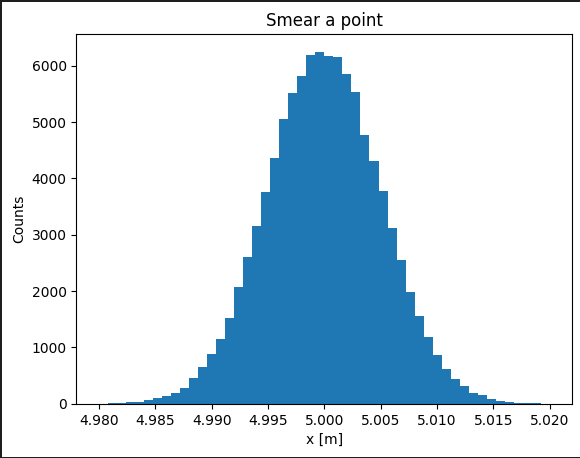

Note the width - it is about 1 cm around the 5, not 2 cm!!

Next we need a function that will smear all the detector hits from one track by this 1 cm. Lets call this `smear_hits` and it takes the list of hits for one track (like `detector_hits[0]`) as an argument, and returns a similar tuple of tuples with each hit smeared in `x` and `y`.

In [ ]:
smear_detector_hits = [smear_hits(x) for x in detector_hits]

Now, repeat the four plots of reconstructed minus generated for the smeared hits.

In the next cell, describe any differences and explain why you see or do not see the differences.

There are little differences. This is because:

* See mis-reconstruction of order 1 cm in the intercept max, and very very small changes in the slope.
* So small because: 1 cm is very very small compared to the m scale we are looking at!
* Slope is so small because we are randomly varying all 4 points - so on average, when we fit 4 points, we will see less than this variance.

## Bonus

Fits are actually much more interesting that what we've done:

* Get errors for the intercept and float out of the fit
* Add errors for the initial points (e.g. smear, but then tell the fitter that each point is only known to +- 1 cm).
* If you coded least squares on your own, find a package to do it, and vice versa.

# Submission

Fantastic! You are done!

To submit this HW:

1. Reset the kernel and run it again top to bottom. The cell numbers for code cells should all be in order!
2. Save this file
3. Use your web browser to print to PDF (or save as PDF) the open notebook.
4. Submit the PDF

You are done!